In [1]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "DI_index"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [2]:
gm12878_bounds = pd.read_csv(src.processed_data_path / "GM12878_25kb_1Mb_boundary_strength.bed", sep="\t")
gm12878_bounds.columns = src.coords + ['bound_strenght', 'cluster_id']
print("GM12878 bounds:", gm12878_bounds.shape[0])
gm12878_bounds.head()

GM12878 bounds: 6073


,chr,start,end,bound_strenght,cluster_id
0,chr1,1025000,1050000,0.005828,0
1,chr1,1850000,1875000,1.892125,1
2,chr1,2300000,2325000,0.012525,2
3,chr1,2500000,2525000,0.002238,3
4,chr1,3375000,3400000,0.116867,4


In [3]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


In [4]:
half_window = 25000
centers = ((consensus_boundaries.start + consensus_boundaries.end) / 2).astype(int)
consensus_boundaries_fixed = consensus_boundaries.copy()
consensus_boundaries_fixed['start'] = centers
consensus_boundaries_fixed['end'] = centers
consensus_boundaries_fixed = BedTool.from_dataframe(consensus_boundaries_fixed)\
                                    .slop(b=half_window, genome='hg19')\
                                    .to_dataframe(names=consensus_boundaries.columns)
consensus_boundaries_fixed.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1587500,1637500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1621875,1671875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1820000,1870000,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2087500,2137500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2321250,2371250,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


In [5]:
consensus_boundaries_fixed_gm12878 = BedTool.from_dataframe(consensus_boundaries_fixed.sort_values(src.coords))\
                                            .map(BedTool.from_dataframe(gm12878_bounds.sort_values(src.coords)), c=1, o='count')\
                                            .to_dataframe(names=consensus_boundaries_fixed.columns.tolist() + ['n_gm12878_bounds'])
consensus_boundaries_fixed_gm12878['has_gm12878_bound'] = consensus_boundaries_fixed_gm12878.n_gm12878_bounds.map(
    lambda x: "Intersects GM12878 boundary" if x>0 else "Does not intersect GM12878 boundary")
consensus_boundaries_fixed_gm12878.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid,n_gm12878_bounds,has_gm12878_bound
0,chr1,1587500,1637500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0,0,Does not intersect GM12878 boundary
1,chr1,1621875,1671875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1,0,Does not intersect GM12878 boundary
2,chr1,1820000,1870000,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2,1,Intersects GM12878 boundary
3,chr1,2087500,2137500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3,0,Does not intersect GM12878 boundary
4,chr1,2321250,2371250,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4,1,Intersects GM12878 boundary


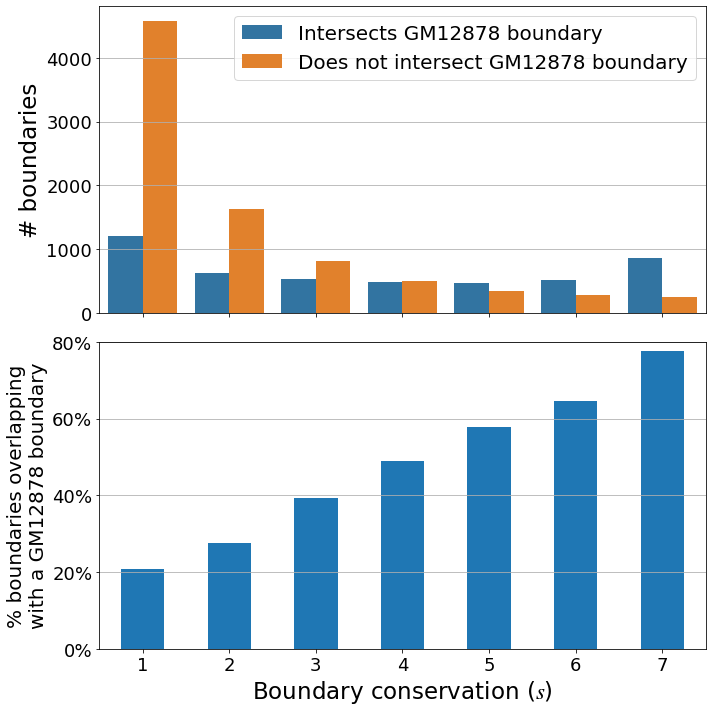

In [13]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10, 10))
sns.countplot(data=consensus_boundaries_fixed_gm12878, x='n_cell_types', 
              hue='has_gm12878_bound', ax=axes[0], hue_order=['Intersects GM12878 boundary', 'Does not intersect GM12878 boundary'])
axes[0].legend()
axes[0].grid(axis='y')
axes[0].set_ylabel("# boundaries", fontsize=23)
axes[0].legend(fontsize=20)
x = consensus_boundaries_fixed_gm12878.groupby(['n_cell_types', 'has_gm12878_bound']).size().unstack()
x = x.div(x.sum(1), axis=0)
x['Intersects GM12878 boundary'].plot.bar(ax=axes[1])
plt.ylim(0, 0.8)
yticks, _ = plt.yticks()
plt.yticks(yticks, ["{:.0f}%".format(yi*100) for yi in yticks], rotation=0)
plt.xticks(rotation=0)
plt.xlabel("Boundary conservation ($s$)", fontsize=23)
plt.ylabel("% boundaries overlapping\nwith a GM12878 boundary", fontsize=20)
fig.savefig(figure_path / "bounds_vs_gm12878bounds_intersects.pdf", bbox_inches='tight', transparent=True)
plt.grid(axis='y')